In [1]:
import os
import numpy as np
import tensorflow as tf
from utils import (
    preprocess_and_load_data,
    add_noise,
    display_image,
    ssim,
    psnr,
    create_experiment_notes,
    tensorboard_callback,
    early_stopping_callback,
    checkpoint_callback,
)

## **Data Collecting**


In [2]:
with tf.device("/device:CPU:0"):
    dataset_path = "/MACHINE LEARNING/DATASET/faceImage"
    file_names = os.listdir(dataset_path)

    total_samples = len(file_names)
    num_train_samples = 8000
    num_test_samples = 2000

    train_file_names = file_names[:num_train_samples]
    test_file_names = file_names[
        num_train_samples : num_train_samples + num_test_samples
    ]

    print(f"Number of samples: {total_samples}")
    print(f"Number of training samples: {num_train_samples}")
    print(f"Number of testing samples: {num_test_samples}")

Number of samples: 70000
Number of training samples: 8000
Number of testing samples: 2000


## **Data Preparation**


### **Load and preprocess training and testing data**


In [3]:
with tf.device("/device:CPU:0"):
    Y_train = preprocess_and_load_data(dataset_path, train_file_names)
    Y_test = preprocess_and_load_data(dataset_path, test_file_names)

### **Add noise to training and testing data**


In [4]:
with tf.device("/device:CPU:0"):
    noise_factor_range_set = [0.3, 0.3, 0.01]
    X_train = add_noise(Y_train, noise_factor_range_set)
    X_test = add_noise(Y_test, noise_factor_range_set)

### **Display some examples of original data and Noisy data**


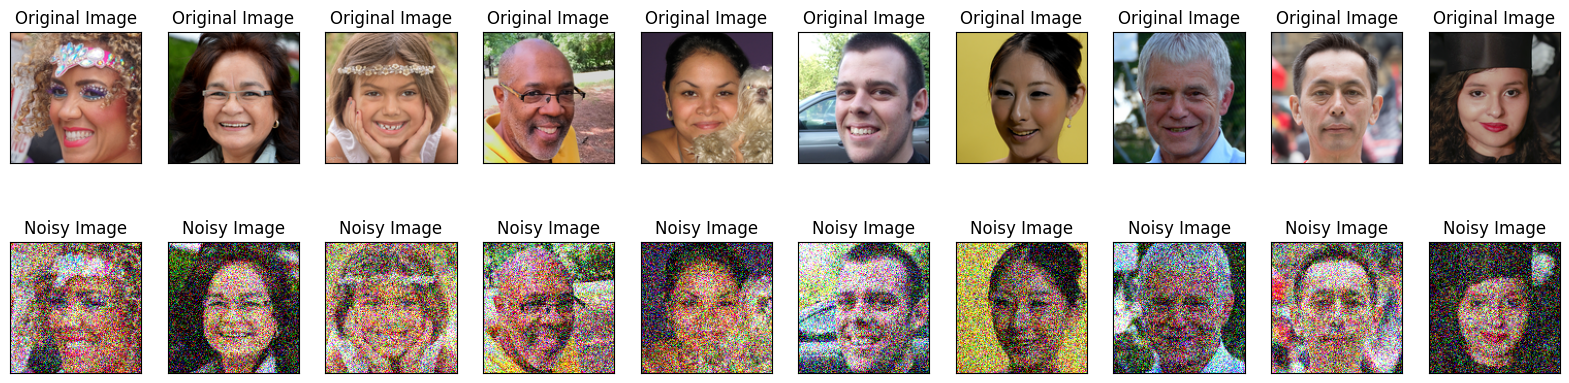

In [5]:
labels = ["Original Image", "Noisy Image"]
with tf.device("/device:CPU:0"):
    rng = np.random.default_rng()
    random_indices = rng.choice(num_train_samples, size=10)
    display_image(Y_train[random_indices], X_train[random_indices], labels=labels)

## **Modelling**


### **Convolutional Autoencoder Model Architecture**


### **Create the autoencoder model**


In [6]:
from mymodel_arch.UNet_Architecture import autoencoder

with tf.device("/device:CPU:0"):
    model_name = "U-Net"
    learning_rate = 1e-4
    optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
    model = autoencoder(optimizer)
    model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 12  3584        ['image_input[0][0]']            
                                8)                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 12  147584      ['conv2d[0][0]']                 
                                8)                                                            

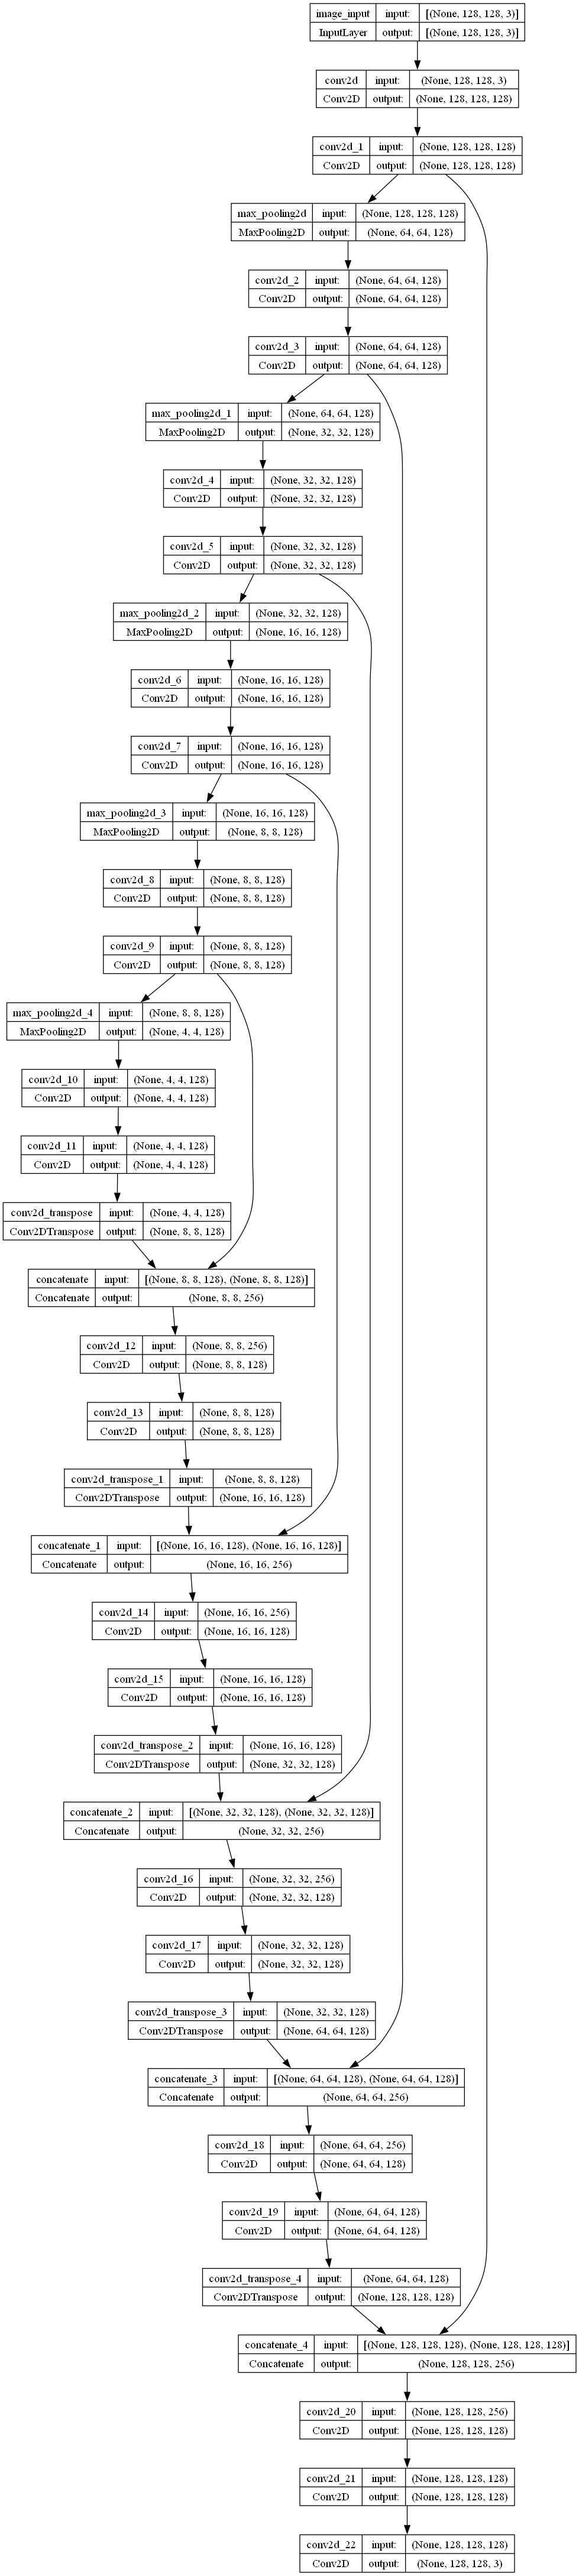

In [7]:
tf.keras.utils.plot_model(
    model, to_file=f"architecture_img/{model_name}.png", show_shapes=True
)

### **Model Callbacks**


In [8]:
with tf.device("/device:CPU:0"):
    checkpoint = checkpoint_callback(f"models/{model_name}.h5")
    early_stopping = early_stopping_callback()
    log_dir, experiment_dir, tensorboard = tensorboard_callback("Image Denoising Log")

## **Model Training**


### **Train the model with noisy training data**


In [9]:
import time

epochs = 100
batch_size = 8
validation_split = 0.2

start_time = time.time()
history = model.fit(
    x=X_train,
    y=Y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=validation_split,
    callbacks=[checkpoint, early_stopping, tensorboard],
)
end_time = time.time()

execution_time = end_time - start_time

Epoch 1/100
800/800 [==============================] - ETA: 0s - loss: 0.0076 - ssim: 0.6497 - psnr: 22.4129
Epoch 1: val_loss improved from inf to 0.00439, saving model to models\U-Net.h5
800/800 [==============================] - 157s 185ms/step - loss: 0.0076 - ssim: 0.6497 - psnr: 22.4129 - val_loss: 0.0044 - val_ssim: 0.6718 - val_psnr: 23.7242
Epoch 2/100
800/800 [==============================] - ETA: 0s - loss: 0.0040 - ssim: 0.6906 - psnr: 24.1181
Epoch 2: val_loss improved from 0.00439 to 0.00367, saving model to models\U-Net.h5
800/800 [==============================] - 194s 242ms/step - loss: 0.0040 - ssim: 0.6906 - psnr: 24.1181 - val_loss: 0.0037 - val_ssim: 0.7123 - val_psnr: 24.5221
Epoch 3/100
800/800 [==============================] - ETA: 0s - loss: 0.0036 - ssim: 0.7231 - psnr: 24.6348
Epoch 3: val_loss improved from 0.00367 to 0.00338, saving model to models\U-Net.h5
800/800 [==============================] - 200s 250ms/step - loss: 0.0036 - ssim: 0.7231 - psnr: 24

### **Plot the Loss, SSIM, and PSNR Graph**


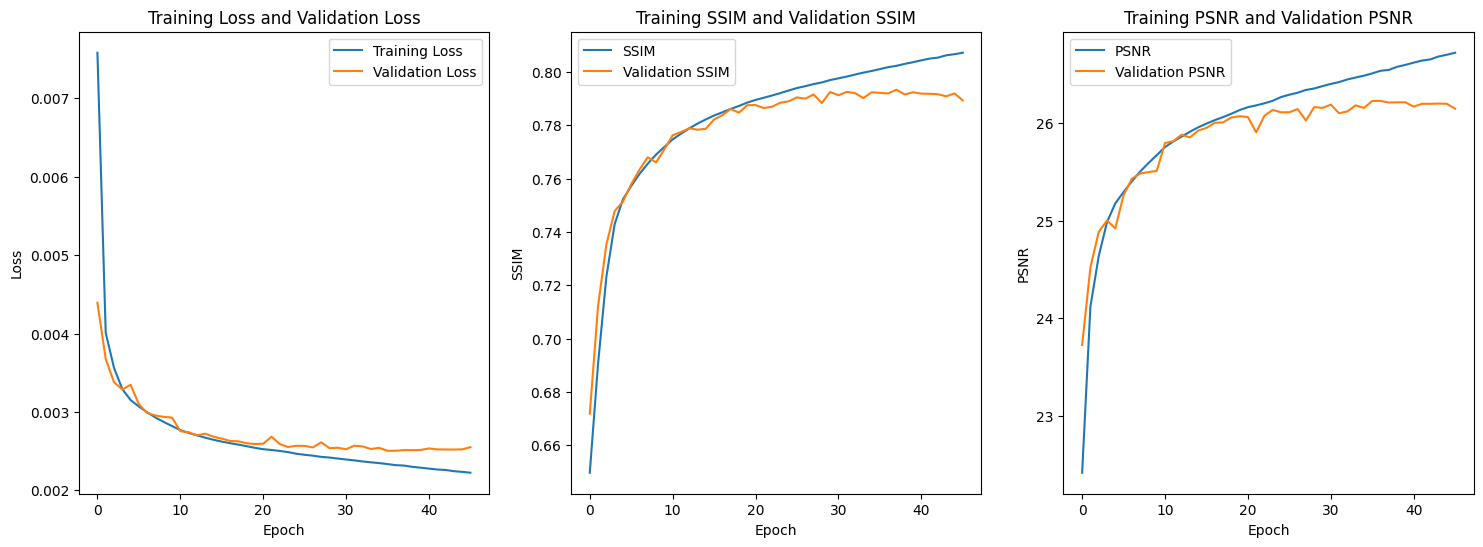

In [10]:
import matplotlib.pyplot as plt

# Plot Training Loss and Validation Loss
plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss and Validation Loss")

# Plot Training SSIM and Validation SSIM
plt.subplot(132)
plt.plot(history.history["ssim"], label="SSIM")
plt.plot(history.history["val_ssim"], label="Validation SSIM")
plt.xlabel("Epoch")
plt.ylabel("SSIM")
plt.legend()
plt.title("Training SSIM and Validation SSIM")

# Plot Training PSNR and Validation PSNR
plt.subplot(133)
plt.plot(history.history["psnr"], label="PSNR")
plt.plot(history.history["val_psnr"], label="Validation PSNR")
plt.xlabel("Epoch")
plt.ylabel("PSNR")
plt.legend()
plt.title("Training PSNR and Validation PSNR")

plt.show()

## **Model Evaluation**


In [11]:
# Load the saved model with custom metric functions
with tf.device("/device:CPU:0"):
    best_model = tf.keras.models.load_model(
        f"models/{model_name}.h5",
        custom_objects={"ssim": ssim, "psnr": psnr},
    )

In [12]:
with tf.device("/device:CPU:0"):
    # Evaluate the model on the test data
    evaluation = best_model.evaluate(X_test, Y_test, batch_size=16)

    # Extract the metrics from the results
    loss, ssim_value, psnr_value = evaluation[0], evaluation[1], evaluation[2]

    # Display the results
    print(f"Test Loss (MSE): {loss}")
    print(f"Test SSIM: {ssim_value}")
    print(f"Test PSNR: {psnr_value}")

125/125 [==============================] - 282s 2s/step - loss: 0.0025 - ssim: 0.7911 - psnr: 26.2007
Test Loss (MSE): 0.002516712760552764
Test SSIM: 0.791087806224823
Test PSNR: 26.200735092163086


### **Experiment Logs**


In [13]:
with tf.device("/device:CPU:0"):
    model_summary_text = []
    for layer in model.layers:
        layer_summary = (
            f"{layer.name} ({layer.__class__.__name__}) {layer.output_shape}"
        )
        model_summary_text.append(layer_summary)

    model_summary_text = "<br/>".join(model_summary_text)

    experiment_notes = create_experiment_notes(
        model_name=model_name,
        model=model_summary_text,
        total_train_data=num_train_samples,
        total_test_data=num_test_samples,
        noise_factor_range_set=noise_factor_range_set,
        learning_rate=learning_rate,
        optimizer=optimizer.__class__.__name__,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        loss=loss,
        ssim_value=ssim_value,
        psnr_value=psnr_value,
        execution_time=execution_time,
    )

    text_file_writer = tf.summary.create_file_writer(log_dir + "/text/")
    with text_file_writer.as_default():
        tf.summary.text(experiment_dir, experiment_notes, step=0)

### **Display test, noisy test data, and predictions image**


1/1 [==============================] - 2s 2s/step


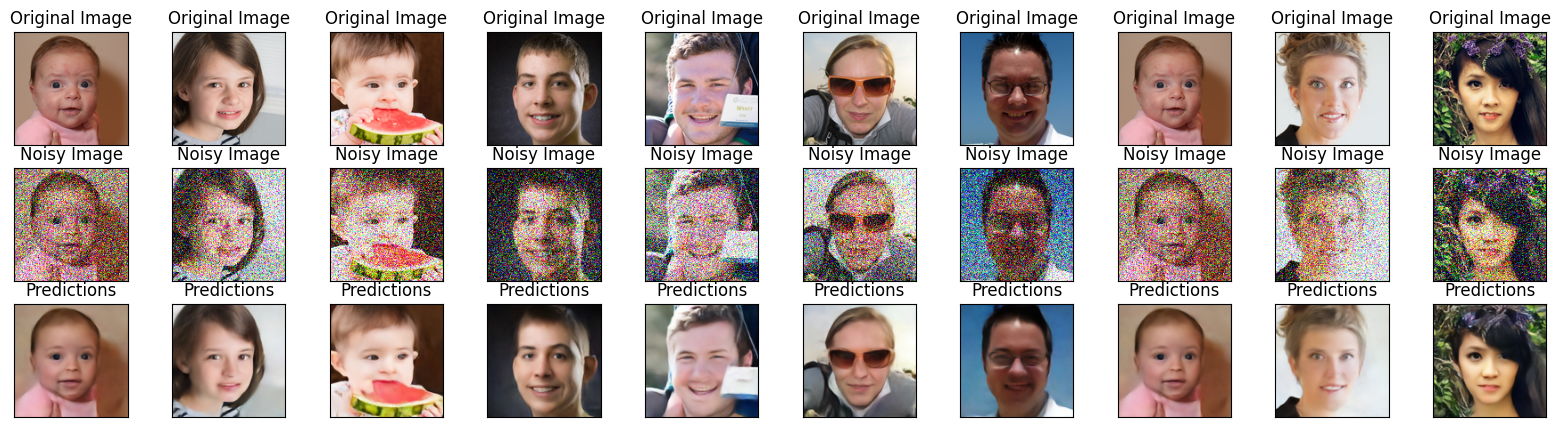

In [14]:
with tf.device("/device:CPU:0"):
    rng = np.random.default_rng()
    random_indices = rng.choice(num_test_samples, size=10)
    labels = ["Original Image", "Noisy Image", "Predictions"]
    predictions = best_model.predict(X_test[random_indices])
    display_image(
        Y_test[random_indices], X_test[random_indices], predictions, labels=labels
    )